In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from astropy.table import Table
import re

In [2]:
#Read the downselected catalog. 
tab = Table.read("Master_AGN_Catalog.downselected.no_r_regions.nostarcut.v1.1.fits")

#### Error on the Proper Motion

We know that the proper motion $pm$ is given by 

$pm^2 = pm_{R.A.}^2 + pm_{Dec}^2$

Then a Gaussian error expansion means that

$\delta pm^2 = \left(\frac{pm_{R.A.}}{pm}\right)^2~\delta pm_{R.A.}^2 + \left(\frac{pm_{Dec}}{pm}\right)^2~\delta pm_{Dec}^2$


In [3]:
#Calculate the proper motion error with a Gaussian expansion.
pm_err = ((tab['pmdec_error'] * tab['pmdec']/tab['pm'])**2 + (tab['pmra_error'] * tab['pmra']/tab['pm'])**2)**0.5

In [4]:
#Calculate the proper motion SNR. Note that this will be a masked array.
#pm_snr = tab['pm'].filled(1.e-2)/pm_err.filled(1.)
pm_snr = tab['pm']/pm_err

In [5]:
def find_short_color_name(b1, b2):
    
    for i, b in enumerate([b1,b2]):
        if b[:8]=="mag_auto":
            bb = b[-1]
        elif b[2:]=="mpro":
            bb = b[:2]
        else:
            print("Cannot find the short filter name. Using the whole name.")
            bb = b
        if i==0:
            c = bb+"-"
        else:
            c = c+bb
    return c
        

In [6]:
#This is a convenience function to display color-color plots.
def plot_color(f1, f2, f3, f4, sel_cond, xmin=None, xmax=None, ymin=None, ymax=None, vmin=1e-2, 
               vmax=1e2, show_nopm_sources=False, stellar_locus=None, quasar_tracks=None):
    
    fig, axs = plt.subplots(1,2,figsize=(16,8), sharex=True, sharey=True)
        
    x = tab[f1]-tab[f2]
    y = tab[f3]-tab[f4]
    color_cond = np.ones(len(tab),dtype=bool)
    if xmin is None:
        for k,f in enumerate([f1,f2,f3,f4]):
            color_cond = color_cond & (tab[f]<99.)
    else:
        axs[0].set_ylim([ymin,ymax])
        axs[0].set_xlim([xmin,xmax])        
    
    #By default, only sources with unmasked pm_snr values (which determines the color) 
    #are shown. To show those sources, we need to fill in the masked values.
    if show_nopm_sources:
        pm_snr_use = pm_snr.filled(vmin)
    else:
        pm_snr_use = pm_snr
        
    #This is the plot for the sources without applying a cut. 
    sc = axs[0].scatter(x[color_cond], y[color_cond], c=pm_snr_use[color_cond], s=1, 
                    cmap='plasma',norm=LogNorm(vmin=vmin,vmax=vmax))
    
    #This one now shows the sources after applying the cut.
    cond = sel_cond & color_cond
    axs[1].scatter(x[cond], y[cond], c=pm_snr_use[cond], s=1, 
                    cmap='plasma',norm=LogNorm(vmin=vmin,vmax=vmax))
    
    #Plot the stellar locus relation if provided.
    c12 = find_short_color_name(f1,f2)
    c34 = find_short_color_name(f3,f4)
    if stellar_locus is not None:
        for ax in axs:
            ax.plot(stellar_locus[c12], stellar_locus[c34], 'k-')
    if quasar_tracks is not None:
        for ax in axs:
            ax.plot(quasar_tracks[c12], quasar_tracks[c34], linestyle='dashed', linewidth=3, color='black')
            ax.plot([quasar_tracks[c12][0]], [quasar_tracks[c34][0]], 'ks',markersize=12)
            for zq in [1.0, 2.0, 3.0, 4.0, 5.0]:
                kz = np.argmin(np.abs(quasar_tracks['Redshift']-zq))
                ax.plot([quasar_tracks[c12][kz]], [quasar_tracks[c34][kz]], 'ko',markersize=7)
            ax.plot([quasar_tracks[c12][-1]], [quasar_tracks[c34][-1]], 'k*',markersize=20)
                
    cb = fig.colorbar(sc, ax=axs.ravel().tolist(), shrink=0.95) #, axs[0])
    cb.set_label(label='PM SNR',size=18,weight='bold')

    axs[0].set_xlabel('{} - {}'.format(f1,f2), fontsize=18)
    axs[1].set_xlabel('{} - {}'.format(f1,f2), fontsize=18)
    axs[0].set_ylabel('{} - {}'.format(f3,f4), fontsize=18)

    plt.show()
    
    return
    

In [7]:
#Read the stellar locus fits form Davenport et al. (2014). We will use the following colors for the analysis: 
#g-i, r-i, r-z, z-W1, r-W1
dv14 = Table.read("Davenport14/table1.txt",format='ascii')
dv14_nir = Table.read("Davenport14/table2.txt",format='ascii')
sl_tab = Table()
sl_tab['g-i']  = dv14['g-i']
sl_tab['r-i']  = dv14['r-i']
sl_tab['r-z']  = dv14['r-i'] + dv14['i-z']
sl_tab['z-w1'] = dv14['z-J'] + dv14['J-H'] + dv14['H-Ks'] + dv14_nir['Ks-W1']
sl_tab['r-w1'] = dv14['r-i'] + dv14['i-z'] + dv14['z-J'] + dv14['J-H'] + dv14['H-Ks'] + dv14_nir['Ks-W1']
sl_tab['w1-w2'] = dv14_nir['W1-W2']

In [8]:
#Read the quasar color tracks.
qcolor = Table.read("quasar_tracks/quasar_tracks.dat", format='ascii')

## I. Pure proper motion cut

The easiest thing is to first cut out the objects that have very significant proper motion detections. This could eliminate some AGN (where due to the variability of the nuclear emission, Gaia could have detected a net proper motion), but hopefully it is not too many. 

**Discuss with team on how much to worry about this**

The condition will be very simple. We will only keep sources that have $SNR_{PM} < 5$. We have to be careful to include objects that have a masked value of the proper motion. 

In [9]:
pm_cond = (pm_snr<5.) | (pm_snr.mask)

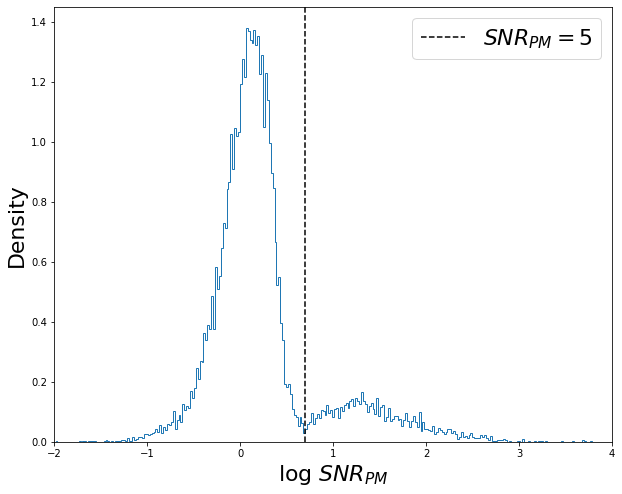

In [10]:
#This plot shows that SNR<5 is a very reasonable cut to make for our sample.
fig, ax = plt.subplots(1, figsize=(10,8))

_ = ax.hist(np.log10(pm_snr[~tab['pm'].mask]), density=True, bins=300, histtype='step')

ax.set_ylim(ax.get_ylim())
ax.plot([np.log10(5.), np.log10(5.)], ax.get_ylim(), 'k--', label=r'$SNR_{PM}=5$')

ax.set_xlim([-2,4])
ax.set_xlabel(r'log $SNR_{PM}$', fontsize=22)
ax.set_ylabel('Density', fontsize=22)

ax.legend(fontsize=22)

plt.show()

In [11]:
print("Number of objects removed: {} ({:.1f}%)".format(len(tab[~pm_cond]),  len(tab[~pm_cond])/len(tab)*100))

Number of objects removed: 2210 (10.2%)


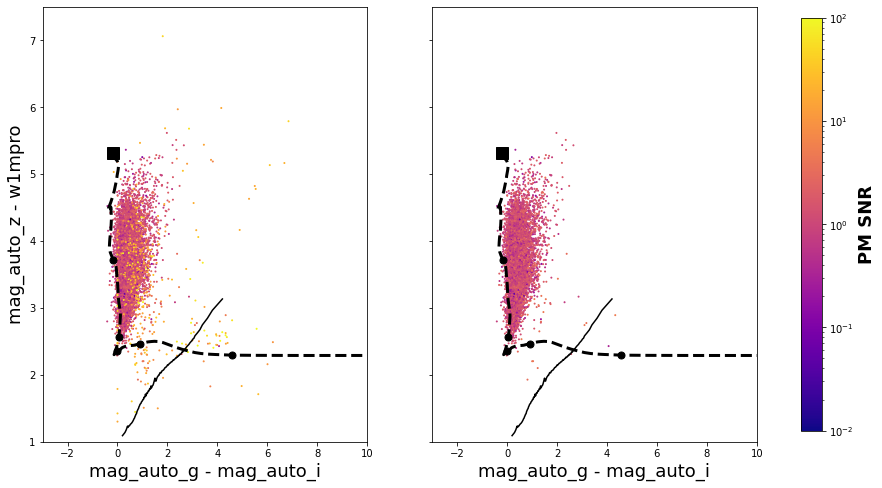

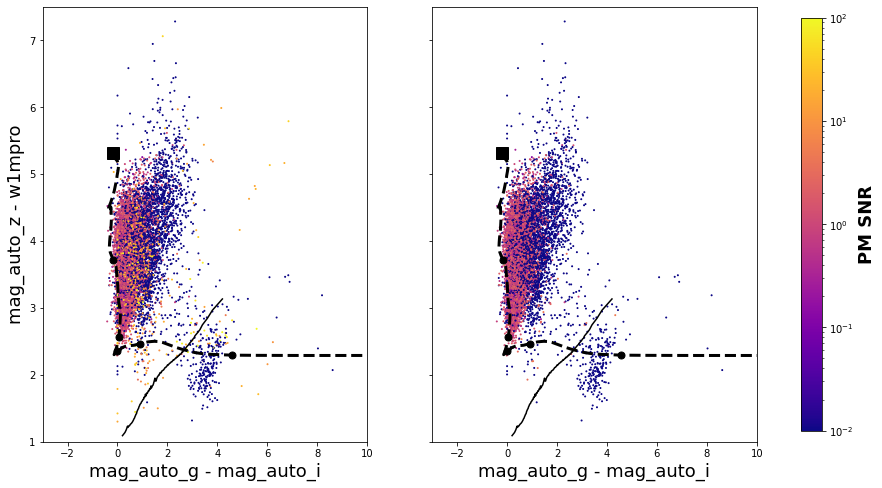

In [12]:
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=pm_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=False, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=pm_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=True, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )

## II. First Color Cut

It is clear that cutting on proper motions is not enough as most sources do not have a measurable proper motion. Hence, we need to apply a color cut. 

From the plots above, it is we get as good enough separation in the g-i vs z-W1 plot (since for this sample we cannot use r and all other cuts are based on having r). 

The cut implemented, then, will be to eliminate everything that is below the stellar locus in that plane, shifted by 0.5 mag up in z-W1. 

In [13]:
#Interpolate the stellar locus tab to create a limit in z-W1 for the r-i color of each source.
zw1_lim = np.interp(tab['mag_auto_g']-tab['mag_auto_i'], sl_tab['g-i'], sl_tab['z-w1']) + 0.5
sl_cut1 = tab['mag_auto_z']-tab['w1mpro']<zw1_lim

#Additionally, since the cut only makes sense for sources detected in all four bands,
#we should require a detection on them. 
for band in ['mag_auto_g', 'mag_auto_i', 'mag_auto_z', 'w1mpro']:
    sl_cut1 = sl_cut1 & (tab[band]<99.)

#Then the full requirement is
sel_cond = pm_cond & (~sl_cut1)

In [14]:
print("Number of objects removed: {} ({:.1f}%)".format(len(tab[~sel_cond]),  len(tab[~sel_cond])/len(tab)*100))

Number of objects removed: 2488 (11.5%)


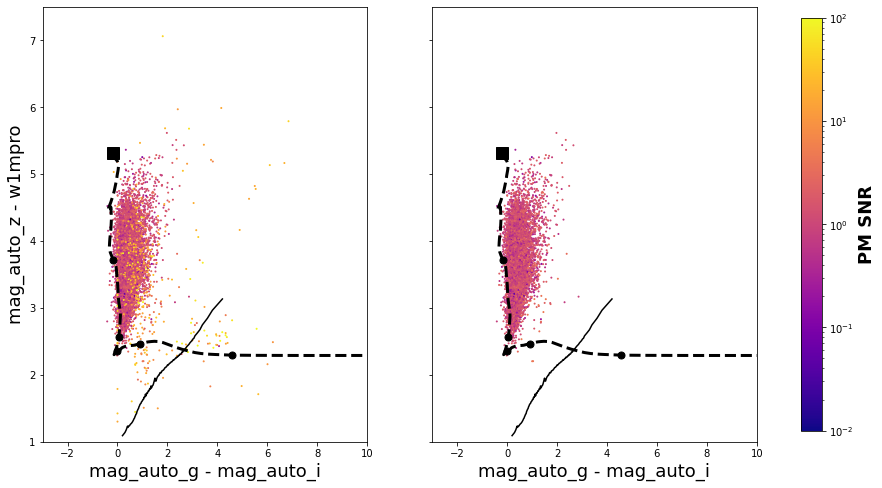

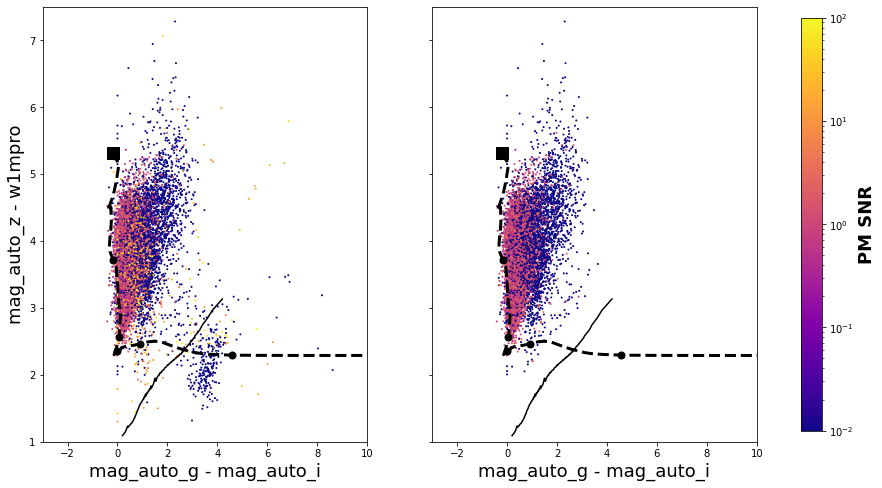

In [15]:
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=sel_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=False, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=sel_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=True, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )

## Check

Finally, check that the cuts were implemented correctly in the automated catalog generation. 

In [16]:
tab = Table.read("Master_AGN_Catalog.downselected.no_r_regions.v1.1.fits")

In [17]:
pm_err = ((tab['pmdec_error'] * tab['pmdec']/tab['pm'])**2 + (tab['pmra_error'] * tab['pmra']/tab['pm'])**2)**0.5
pm_snr = tab['pm']/pm_err

In [18]:
sel_cond = np.ones(len(pm_snr),dtype=bool)

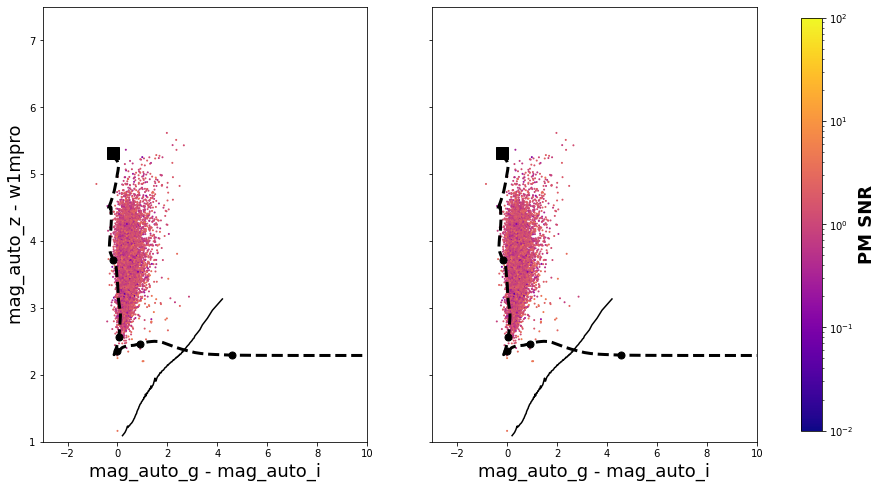

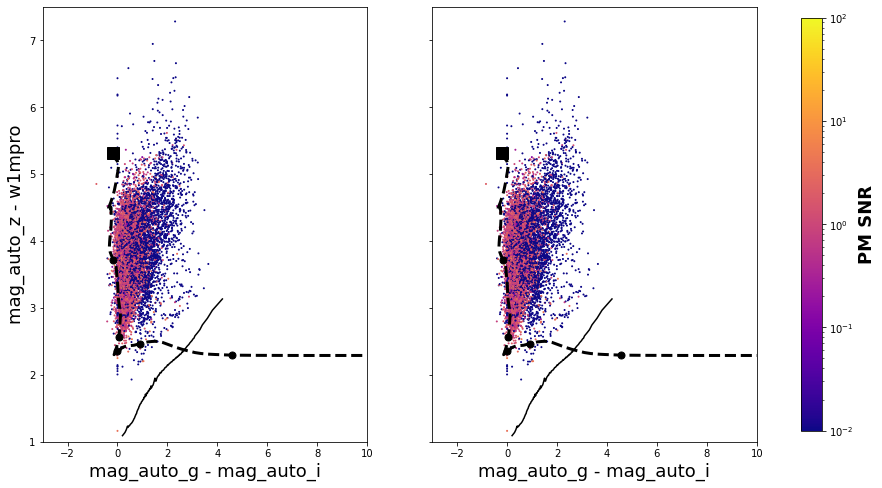

In [19]:
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=sel_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=False, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )
plot_color('mag_auto_g','mag_auto_i','mag_auto_z','w1mpro',sel_cond=sel_cond,
           xmin=-3.0, xmax=10.0, ymin=1.0, ymax=7.5,
           show_nopm_sources=True, stellar_locus=sl_tab, quasar_tracks=qcolor,
          )